In [1]:
import pandas as pd
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras import layers, models

In [2]:
df =pd.read_csv("dataset_file_directory.csv")


In [3]:
p11_dataset =df[df['Participant']== 'P11']
p11_datasets =p11_dataset[~p11_dataset['Label'].isin(['greeting'])]

In [4]:
classess=p11_datasets['Label'].value_counts()

In [5]:
classess

delighted       207
social           52
selftalk         33
frustrated       27
dysregulated     22
request          22
Name: Label, dtype: int64

In [6]:
p11_datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363 entries, 5935 to 6297
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     363 non-null    object
 1   Participant  363 non-null    object
 2   Label        363 non-null    object
dtypes: object(3)
memory usage: 11.3+ KB


In [7]:
# Specify the directory where your Python script is located
script_dir = r"C:\Users\pawan\Desktop\mv\downloaddataset"
# Define the relative path to the WAV files directory
wav_dir = os.path.join(script_dir, "downloaded_wav_files")

In [8]:
def extract_audio_features(dataset):
    null_file = 0
    
    for index, row in dataset.iterrows():
        filename = row['Filename']
        participant = row['Participant']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)

        # Check if the audio file exists before attempting to load it
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None) 
                # Perform feature extraction (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
                chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
                spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=13)
                stft = librosa.stft(audio_data)
                fft_features = np.abs(stft)
                rmse = librosa.feature.rms(y=audio_data)
                
                fft_features_db = librosa.amplitude_to_db(fft_features, ref=np.max)

            # Calculate the mean of FFT features
                fft_features_mean = np.mean(fft_features_db, axis=1)
                rmse_mean = np.mean(rmse)
                mfccs_mean = np.mean(mfccs, axis=1)
                chroma_mean = np.mean(chroma, axis=1)
                spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
                mel_spectrogram_mean = np.mean(mel_spectrogram, axis=1)
                
                # Combine the extracted features into a single vector
                combined_mmcs=np.hstack((mfccs_mean,mel_spectrogram_mean,chroma_mean,spectral_contrast_mean))
                combined_feature_vector = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean, mel_spectrogram_mean, fft_features_mean, rmse_mean))
                mf_mel=np.hstack((mfccs_mean,mel_spectrogram_mean))
                mf_co=np.hstack((mfccs_mean,chroma_mean))
                mf_ch=np.hstack((mfccs_mean,spectral_contrast_mean))
                # Append the extracted features and label to the lists
                mf_ch_list.append(mf_mel)
                mf_co_list.append(mf_ch)
                mf_mel_list.append(mf_co)
                mfcc_fe.append(mfccs_mean)
                rmse_fe.append(rmse_mean)
                chroma_fe.append(chroma_mean)
                spectral_constrast_fe.append(spectral_contrast_mean)
                mel_spectrogram_fe.append(mel_spectrogram_mean)
                fft_fe.append(fft_features_mean)
                combined_4.append(combined_mmcs)
                combined_fe.append(combined_feature_vector)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            null_file += 1
            print(f"Audio file not found: {wav_file_path}")

    print("Related audio files not found count:", null_file)

    return null_file


In [9]:
mfcc_fe=[]
rmse_fe=[]
chroma_fe=[]
spectral_constrast_fe=[]
mel_spectrogram_fe=[]
fft_fe=[]

#fusion of mfcc+mel,fusion of mfcc + contrast,mfcc+chroma
mf_ch_list=[]
mf_co_list=[]
mf_mel_list=[]
combined_4=[]
labels_list=[]
combined_fe=[]
extract_audio_features(p11_datasets)


Related audio files not found count: 0


0

In [10]:
X_mfcc_fe  = np.array(mfcc_fe)
X_rmse_fe  = np.array(rmse_fe)
X_chroma_fe  = np.array(chroma_fe)
X_spectral_constrast_fe= np.array(spectral_constrast_fe)
X_mel_spectrogram_fe= np.array(mel_spectrogram_fe)
X_fft_fe= np.array(fft_fe)

X_mf_ch=np.array(mf_ch_list)
X_mf_co=np.array(mf_co_list)
X_mf_mel=np.array(mf_mel_list)
X_combined=np.array(combined_4)

y=np.array(labels_list)

In [11]:
X_mel_spectrogram_fe.shape

(363, 13)

In [12]:
# Encode the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train_mfccs, X_test_mfccs, y_train1, y_test1 = train_test_split(X_mfcc_fe, y_encoded, test_size=0.2, random_state=42)
X_train_chroma, X_test_chroma, _, _ = train_test_split(X_chroma_fe, y_encoded, test_size=0.2, random_state=42)
X_train_spectral_contrast, X_test_spectral_contrast, _, _ = train_test_split(X_spectral_constrast_fe, y_encoded, test_size=0.2, random_state=42)
X_train_mel_spectrogram, X_test_mel_spectrogram, _, _ = train_test_split(X_mel_spectrogram_fe, y_encoded, test_size=0.2, random_state=42)
X_train_fft, X_test_fft, _, _ = train_test_split(X_fft_fe, y_encoded, test_size=0.2, random_state=42)
X_train_rmse, X_test_rmse, _, _ = train_test_split(X_rmse_fe, y_encoded, test_size=0.2, random_state=42)

X_mf_ch_train, X_mf_ch_test, _,_ = train_test_split(X_mf_ch, y_encoded, test_size=0.2, random_state=42)
X_mf_co_train, X_mf_co_test, _, _ = train_test_split(X_mf_co, y_encoded, test_size=0.2, random_state=42)
X_mf_mel_train, X_mf_mel_test, _, _ = train_test_split(X_mf_mel, y_encoded, test_size=0.2, random_state=42)
X_combined_train, X_combined_test, _, _ = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)



In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
def cnn_model(X_train,y_train,X_test,y_test):
    n_classes=p11_datasets['Label'].nunique()
    model = models.Sequential([
        layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    
        # Add more convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Flatten(),
    
        # Add more dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
    
        layers.Dense(n_classes, activation='softmax') 
    ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, 
                   validation_split=0.2, 
                    batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    accuracy_stack.append(test_accuracy)
    print(f"Test accuracy: {test_accuracy}")
    
    return model


def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape, )),  # Reshape for 1D convolution

        # Convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.Conv1D(256, 3, activation='relu', padding='same'),

        # Flatten layer
        layers.Flatten(),

        # Fully connected layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:
accuracy_stack=[]

In [15]:

cnn_model(X_train_mfccs,y_train1,X_test_mfccs,y_test1)

Epoch 1/50
6/6 [==============================] - 1s 88ms/step - loss: 4.8165 - accuracy: 0.3362 - val_loss: 1.3468 - val_accuracy: 0.5690
Epoch 2/50
6/6 [==============================] - 0s 22ms/step - loss: 2.2425 - accuracy: 0.3750 - val_loss: 1.4095 - val_accuracy: 0.5690
Epoch 3/50
6/6 [==============================] - 0s 22ms/step - loss: 1.8192 - accuracy: 0.4353 - val_loss: 1.3978 - val_accuracy: 0.5690
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 1.6467 - accuracy: 0.4052 - val_loss: 1.4107 - val_accuracy: 0.5690
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 1.5137 - accuracy: 0.5172 - val_loss: 1.4007 - val_accuracy: 0.5690
Epoch 6/50
6/6 [==============================] - 0s 17ms/step - loss: 1.4022 - accuracy: 0.5560 - val_loss: 1.3558 - val_accuracy: 0.5690
Epoch 7/50
6/6 [==============================] - 0s 20ms/step - loss: 1.4835 - accuracy: 0.5086 - val_loss: 1.3149 - val_accuracy: 0.5690
Epoch 8/50
6/6 [===========

In [16]:
cnn_model(X_train_chroma,y_train1,X_test_chroma,y_test1)

Epoch 1/50
6/6 [==============================] - 1s 75ms/step - loss: 1.7418 - accuracy: 0.4181 - val_loss: 1.5932 - val_accuracy: 0.5690
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 1.4795 - accuracy: 0.5862 - val_loss: 1.4203 - val_accuracy: 0.5690
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 1.4072 - accuracy: 0.5862 - val_loss: 1.3785 - val_accuracy: 0.5690
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 1.3290 - accuracy: 0.5862 - val_loss: 1.3809 - val_accuracy: 0.5690
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 1.3617 - accuracy: 0.5862 - val_loss: 1.3790 - val_accuracy: 0.5690
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 1.3375 - accuracy: 0.5862 - val_loss: 1.3636 - val_accuracy: 0.5690
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 1.3561 - accuracy: 0.5862 - val_loss: 1.3940 - val_accuracy: 0.5690
Epoch 8/50
6/6 [===========

In [17]:
cnn_model(X_train_mel_spectrogram,y_train1,X_test_mel_spectrogram,y_test1)

Epoch 1/50
6/6 [==============================] - 1s 78ms/step - loss: 1.9115 - accuracy: 0.3922 - val_loss: 1.4235 - val_accuracy: 0.5690
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 1.7439 - accuracy: 0.5474 - val_loss: 1.4346 - val_accuracy: 0.5690
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 1.6484 - accuracy: 0.5603 - val_loss: 1.4100 - val_accuracy: 0.5690
Epoch 4/50
6/6 [==============================] - 0s 15ms/step - loss: 1.6078 - accuracy: 0.5086 - val_loss: 1.4114 - val_accuracy: 0.5690
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 1.5920 - accuracy: 0.5517 - val_loss: 1.4031 - val_accuracy: 0.5690
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 1.5231 - accuracy: 0.5905 - val_loss: 1.3691 - val_accuracy: 0.5690
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 1.4993 - accuracy: 0.5819 - val_loss: 1.3938 - val_accuracy: 0.5690
Epoch 8/50
6/6 [===========

In [18]:

cnn_model(X_train_fft, y_train1, X_test_fft, y_test1)


Epoch 1/50
6/6 [==============================] - 2s 173ms/step - loss: 28.1160 - accuracy: 0.2629 - val_loss: 3.5955 - val_accuracy: 0.5690
Epoch 2/50
6/6 [==============================] - 1s 116ms/step - loss: 2.7256 - accuracy: 0.3319 - val_loss: 1.4065 - val_accuracy: 0.5690
Epoch 3/50
6/6 [==============================] - 1s 107ms/step - loss: 1.6289 - accuracy: 0.4310 - val_loss: 1.5873 - val_accuracy: 0.5690
Epoch 4/50
6/6 [==============================] - 1s 110ms/step - loss: 1.5817 - accuracy: 0.5431 - val_loss: 1.4311 - val_accuracy: 0.5690
Epoch 5/50
6/6 [==============================] - 1s 113ms/step - loss: 1.5241 - accuracy: 0.5345 - val_loss: 1.4743 - val_accuracy: 0.5690
Epoch 6/50
6/6 [==============================] - 1s 113ms/step - loss: 1.5200 - accuracy: 0.5259 - val_loss: 1.4016 - val_accuracy: 0.5690
Epoch 7/50
6/6 [==============================] - 1s 111ms/step - loss: 1.4623 - accuracy: 0.5603 - val_loss: 1.3876 - val_accuracy: 0.5690
Epoch 8/50
6/6 [===

In [19]:
X_train_rmse.shape


(290,)

In [20]:

model2=create_cnn_model(1,6)
history = model2.fit(X_train_rmse, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model2.evaluate(X_test_rmse, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/10
6/6 [==============================] - 1s 75ms/step - loss: 1.7744 - accuracy: 0.5086 - val_loss: 1.7359 - val_accuracy: 0.5690
Epoch 2/10
6/6 [==============================] - 0s 15ms/step - loss: 1.7025 - accuracy: 0.5862 - val_loss: 1.6008 - val_accuracy: 0.5690
Epoch 3/10
6/6 [==============================] - 0s 16ms/step - loss: 1.5212 - accuracy: 0.5862 - val_loss: 1.3672 - val_accuracy: 0.5690
Epoch 4/10
6/6 [==============================] - 0s 16ms/step - loss: 1.4264 - accuracy: 0.5862 - val_loss: 1.3851 - val_accuracy: 0.5690
Epoch 5/10
6/6 [==============================] - 0s 14ms/step - loss: 1.4342 - accuracy: 0.5862 - val_loss: 1.3301 - val_accuracy: 0.5690
Epoch 6/10
6/6 [==============================] - 0s 14ms/step - loss: 1.3752 - accuracy: 0.5862 - val_loss: 1.3356 - val_accuracy: 0.5690
Epoch 7/10
6/6 [==============================] - 0s 15ms/step - loss: 1.3777 - accuracy: 0.5862 - val_loss: 1.3253 - val_accuracy: 0.5690
Epoch 8/10
6/6 [===========

In [21]:


model1=create_cnn_model(7,6)
history = model1.fit(X_train_spectral_contrast, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model1.evaluate(X_test_spectral_contrast, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/10
6/6 [==============================] - 1s 102ms/step - loss: 1.7944 - accuracy: 0.4526 - val_loss: 1.3675 - val_accuracy: 0.5690
Epoch 2/10
6/6 [==============================] - 0s 19ms/step - loss: 1.6291 - accuracy: 0.4267 - val_loss: 1.3751 - val_accuracy: 0.5690
Epoch 3/10
6/6 [==============================] - 0s 19ms/step - loss: 1.4789 - accuracy: 0.5388 - val_loss: 1.3948 - val_accuracy: 0.5690
Epoch 4/10
6/6 [==============================] - 0s 16ms/step - loss: 1.4542 - accuracy: 0.5603 - val_loss: 1.3661 - val_accuracy: 0.5690
Epoch 5/10
6/6 [==============================] - 0s 12ms/step - loss: 1.4749 - accuracy: 0.5776 - val_loss: 1.3585 - val_accuracy: 0.5690
Epoch 6/10
6/6 [==============================] - 0s 16ms/step - loss: 1.4677 - accuracy: 0.5776 - val_loss: 1.3688 - val_accuracy: 0.5690
Epoch 7/10
6/6 [==============================] - 0s 16ms/step - loss: 1.3885 - accuracy: 0.5819 - val_loss: 1.3945 - val_accuracy: 0.5690
Epoch 8/10
6/6 [==========

In [22]:
cnn_model(X_mf_ch_train,y_train1,X_mf_ch_test,y_test1)

Epoch 1/50
6/6 [==============================] - 1s 84ms/step - loss: 5.3734 - accuracy: 0.3534 - val_loss: 1.6050 - val_accuracy: 0.5690
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 2.4105 - accuracy: 0.3879 - val_loss: 1.4779 - val_accuracy: 0.5690
Epoch 3/50
6/6 [==============================] - 0s 19ms/step - loss: 2.0374 - accuracy: 0.3879 - val_loss: 1.2788 - val_accuracy: 0.5690
Epoch 4/50
6/6 [==============================] - 0s 22ms/step - loss: 1.6220 - accuracy: 0.4526 - val_loss: 1.2725 - val_accuracy: 0.5690
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 1.4864 - accuracy: 0.5172 - val_loss: 1.3053 - val_accuracy: 0.5690
Epoch 6/50
6/6 [==============================] - 0s 19ms/step - loss: 1.4719 - accuracy: 0.5345 - val_loss: 1.3142 - val_accuracy: 0.5690
Epoch 7/50
6/6 [==============================] - 0s 20ms/step - loss: 1.4231 - accuracy: 0.5259 - val_loss: 1.3136 - val_accuracy: 0.5690
Epoch 8/50
6/6 [===========

In [23]:
cnn_model(X_mf_co_train,y_train1,X_mf_co_test,y_test1)

Epoch 1/50
6/6 [==============================] - 1s 82ms/step - loss: 4.1417 - accuracy: 0.3448 - val_loss: 2.0197 - val_accuracy: 0.5690
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 2.9684 - accuracy: 0.3879 - val_loss: 1.4482 - val_accuracy: 0.5690
Epoch 3/50
6/6 [==============================] - 0s 20ms/step - loss: 1.7276 - accuracy: 0.4353 - val_loss: 1.3703 - val_accuracy: 0.5690
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 1.6024 - accuracy: 0.4871 - val_loss: 1.3550 - val_accuracy: 0.5690
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 1.5015 - accuracy: 0.5172 - val_loss: 1.3310 - val_accuracy: 0.5690
Epoch 6/50
6/6 [==============================] - 0s 19ms/step - loss: 1.5279 - accuracy: 0.5560 - val_loss: 1.3563 - val_accuracy: 0.5690
Epoch 7/50
6/6 [==============================] - 0s 22ms/step - loss: 1.4277 - accuracy: 0.5086 - val_loss: 1.3794 - val_accuracy: 0.5690
Epoch 8/50
6/6 [===========

In [24]:
cnn_model(X_mf_mel_train,y_train1,X_mf_mel_test,y_test1)

Epoch 1/50
6/6 [==============================] - 1s 83ms/step - loss: 4.9396 - accuracy: 0.3017 - val_loss: 1.9054 - val_accuracy: 0.5690
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 2.6836 - accuracy: 0.4310 - val_loss: 1.3387 - val_accuracy: 0.5690
Epoch 3/50
6/6 [==============================] - 0s 22ms/step - loss: 1.8580 - accuracy: 0.4612 - val_loss: 1.3582 - val_accuracy: 0.5690
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 1.6026 - accuracy: 0.4440 - val_loss: 1.4178 - val_accuracy: 0.5690
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 1.5405 - accuracy: 0.5388 - val_loss: 1.3268 - val_accuracy: 0.5690
Epoch 6/50
6/6 [==============================] - 0s 20ms/step - loss: 1.4599 - accuracy: 0.5474 - val_loss: 1.3414 - val_accuracy: 0.5690
Epoch 7/50
6/6 [==============================] - 0s 22ms/step - loss: 1.4636 - accuracy: 0.5172 - val_loss: 1.3698 - val_accuracy: 0.5690
Epoch 8/50
6/6 [===========

In [25]:
cnn_model(X_combined_train,y_train1,X_combined_test,y_test1)

Epoch 1/50
6/6 [==============================] - 1s 85ms/step - loss: 4.4199 - accuracy: 0.3922 - val_loss: 1.6081 - val_accuracy: 0.5690
Epoch 2/50
6/6 [==============================] - 0s 25ms/step - loss: 2.1956 - accuracy: 0.3534 - val_loss: 1.3329 - val_accuracy: 0.5690
Epoch 3/50
6/6 [==============================] - 0s 22ms/step - loss: 1.7654 - accuracy: 0.4526 - val_loss: 1.3319 - val_accuracy: 0.5690
Epoch 4/50
6/6 [==============================] - 0s 22ms/step - loss: 1.5171 - accuracy: 0.4828 - val_loss: 1.3452 - val_accuracy: 0.5690
Epoch 5/50
6/6 [==============================] - 0s 25ms/step - loss: 1.5190 - accuracy: 0.5129 - val_loss: 1.3417 - val_accuracy: 0.5690
Epoch 6/50
6/6 [==============================] - 0s 22ms/step - loss: 1.4497 - accuracy: 0.5345 - val_loss: 1.4406 - val_accuracy: 0.5690
Epoch 7/50
6/6 [==============================] - 0s 24ms/step - loss: 1.4707 - accuracy: 0.5388 - val_loss: 1.3818 - val_accuracy: 0.5690
Epoch 8/50
6/6 [===========

In [26]:
accuracy_stack

[0.5205479264259338,
 0.5479452013969421,
 0.5479452013969421,
 0.5205479264259338,
 0.5205479264259338,
 0.5205479264259338,
 0.5616438388824463,
 0.5890411138534546,
 0.5753424763679504,
 0.5753424763679504]

In [27]:
labels=p11_datasets['Label'].unique()

In [28]:
labels

array(['frustrated', 'dysregulated', 'social', 'selftalk', 'request',
       'delighted'], dtype=object)

In [29]:
import time
import matplotlib.pyplot as plt
# Define a function to train and evaluate a CNN model
def train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=10):
    start_time = time.time()

    model = create_cnn_model(input_shape, num_classes)
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    end_time = time.time()

    return model, history, test_accuracy, end_time - start_time

# List of models and their input shapes
models_to_evaluate = [
    (X_train_mfccs, y_train1, X_test_mfccs, y_test1, X_train_mfccs.shape[1], len(set(labels))),
    (X_train_chroma, y_train1, X_test_chroma, y_test1, X_train_chroma.shape[1], len(set(labels))),
    (X_train_mel_spectrogram, y_train1, X_test_mel_spectrogram, y_test1, X_train_mel_spectrogram.shape[1], len(set(labels))),
    (X_train_fft, y_train1, X_test_fft, y_test1, X_train_fft.shape[1], len(set(labels))),
    (X_train_rmse, y_train1, X_test_rmse, y_test1, 1, len(set(labels))),
    (X_train_spectral_contrast, y_train1, X_test_spectral_contrast, y_test1,7, len(set(labels))),
    (X_mf_ch_train, y_train1, X_mf_ch_test, y_test1, X_mf_ch_train.shape[1], len(set(labels))),
    (X_mf_co_train, y_train1, X_mf_co_test, y_test1, X_mf_co_train.shape[1], len(set(labels))),
    (X_mf_mel_train, y_train1, X_mf_mel_test, y_test1, X_mf_mel_train.shape[1], len(set(labels))),
    (X_combined_train, y_train1, X_combined_test, y_test1, X_combined_train.shape[1], len(set(labels)))
]

# Train and evaluate models, and collect their accuracies and execution times
model_accuracies = []
execution_times = []

for X_train, y_train, X_test, y_test, input_shape, num_classes in models_to_evaluate:
    model, _, test_accuracy, execution_time = train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes)
    model_accuracies.append(test_accuracy)
    execution_times.append(execution_time)



Epoch 1/10
6/6 [==============================] - 1s 94ms/step - loss: 5.8533 - accuracy: 0.3707 - val_loss: 1.4941 - val_accuracy: 0.5690
Epoch 2/10
6/6 [==============================] - 0s 35ms/step - loss: 2.7847 - accuracy: 0.3491 - val_loss: 1.3342 - val_accuracy: 0.5690
Epoch 3/10
6/6 [==============================] - 0s 35ms/step - loss: 1.6212 - accuracy: 0.4440 - val_loss: 1.4189 - val_accuracy: 0.5690
Epoch 4/10
6/6 [==============================] - 0s 34ms/step - loss: 1.5235 - accuracy: 0.5603 - val_loss: 1.3368 - val_accuracy: 0.5690
Epoch 5/10
6/6 [==============================] - 0s 33ms/step - loss: 1.3962 - accuracy: 0.5647 - val_loss: 1.4058 - val_accuracy: 0.5690
Epoch 6/10
6/6 [==============================] - 0s 34ms/step - loss: 1.4386 - accuracy: 0.5560 - val_loss: 1.3106 - val_accuracy: 0.5690
Epoch 7/10
6/6 [==============================] - 0s 34ms/step - loss: 1.4882 - accuracy: 0.5776 - val_loss: 1.3373 - val_accuracy: 0.5690
Epoch 8/10
6/6 [===========

Epoch 7/10
6/6 [==============================] - 0s 16ms/step - loss: 1.4407 - accuracy: 0.5819 - val_loss: 1.3945 - val_accuracy: 0.5690
Epoch 8/10
6/6 [==============================] - 0s 16ms/step - loss: 1.4295 - accuracy: 0.5776 - val_loss: 1.4047 - val_accuracy: 0.5690
Epoch 9/10
6/6 [==============================] - 0s 19ms/step - loss: 1.4198 - accuracy: 0.5862 - val_loss: 1.3618 - val_accuracy: 0.5690
Epoch 10/10
3/3 [==============================] - 0s 5ms/step - loss: 1.4639 - accuracy: 0.5205
Epoch 1/10
6/6 [==============================] - 1s 99ms/step - loss: 4.1204 - accuracy: 0.3491 - val_loss: 1.5488 - val_accuracy: 0.5690
Epoch 2/10
6/6 [==============================] - 0s 40ms/step - loss: 1.8452 - accuracy: 0.4224 - val_loss: 1.3548 - val_accuracy: 0.5690
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 1.4610 - accuracy: 0.5216 - val_loss: 1.3333 - val_accuracy: 0.5690
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - loss

In [30]:
print(model_accuracies)
print(" ")
print(accuracy_stack)

[0.5205479264259338, 0.5205479264259338, 0.5616438388824463, 0.5205479264259338, 0.5205479264259338, 0.5205479264259338, 0.5205479264259338, 0.5205479264259338, 0.534246563911438, 0.5205479264259338]
 
[0.5205479264259338, 0.5479452013969421, 0.5479452013969421, 0.5205479264259338, 0.5205479264259338, 0.5205479264259338, 0.5616438388824463, 0.5890411138534546, 0.5753424763679504, 0.5753424763679504]


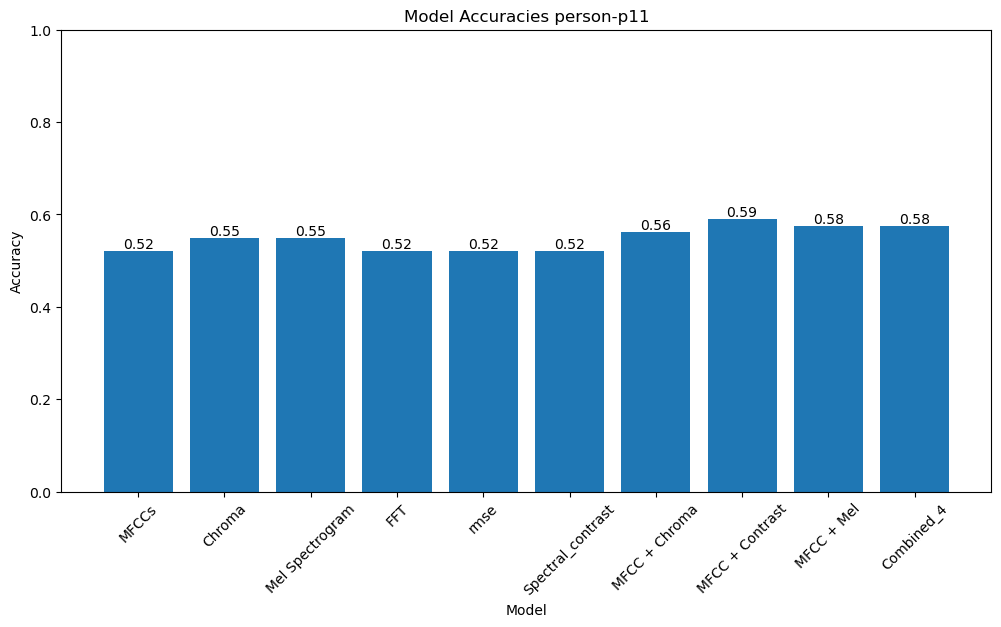

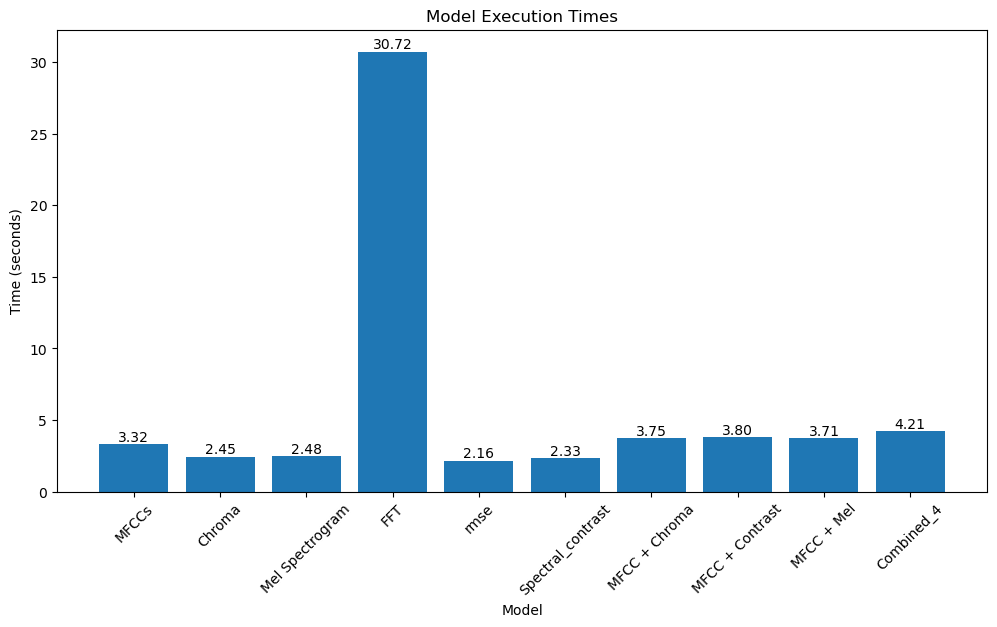

In [34]:

# Plot model accuracies
model_names = [
    "MFCCs", "Chroma", "Mel Spectrogram", "FFT","rmse","Spectral_contrast",
    "MFCC + Chroma", "MFCC + Contrast", "MFCC + Mel","Combined_4"
]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, accuracy_stack)
plt.title("Model Accuracies person-p11")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Annotate each bar with its accuracy value
for bar, accuracy in zip(bars, accuracy_stack):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()
# Plot execution times
plt.figure(figsize=(12, 6))
bar1=plt.bar(model_names, execution_times)
plt.title("Model Execution Times")
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)
for bar1, time in zip(bar1, execution_times):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), f'{time:.2f}', ha='center', va='bottom')

plt.show()


In [37]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define a function to train and evaluate a CNN model
def train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=10):
    start_time = time.time()

    model = create_cnn_model(input_shape, num_classes)  # Implement your create_cnn_model function
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    end_time = time.time()

    return model, history, test_accuracy, end_time - start_time

# List of models and their input shapes
models_to_evaluate = [
    (X_train_mfccs, y_train1, X_test_mfccs, y_test1, X_train_mfccs.shape[1], len(set(labels))),
    (X_train_chroma, y_train1, X_test_chroma, y_test1, X_train_chroma.shape[1], len(set(labels))),
    (X_train_mel_spectrogram, y_train1, X_test_mel_spectrogram, y_test1, X_train_mel_spectrogram.shape[1], len(set(labels))),
    (X_train_fft, y_train1, X_test_fft, y_test1, X_train_fft.shape[1], len(set(labels))),
    (X_train_rmse, y_train1, X_test_rmse, y_test1, 1, len(set(labels))),
    (X_train_spectral_contrast, y_train1, X_test_spectral_contrast, y_test1, 7, len(set(labels))),
    (X_mf_ch_train, y_train1, X_mf_ch_test, y_test1, X_mf_ch_train.shape[1], len(set(labels))),
    (X_mf_co_train, y_train1, X_mf_co_test, y_test1, X_mf_co_train.shape[1], len(set(labels))),
    (X_mf_mel_train, y_train1, X_mf_mel_test, y_test1, X_mf_mel_train.shape[1], len(set(labels))),
    (X_combined_train, y_train1, X_combined_test, y_test1, X_combined_train.shape[1], len(set(labels)))
]

# Train and evaluate models, and collect their accuracies and execution times
model_accuracies = []
execution_times = []

for X_train, y_train, X_test, y_test, input_shape, num_classes in models_to_evaluate:
    model, _, test_accuracy, execution_time = train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes)
    model_accuracies.append(test_accuracy)
    execution_times.append(execution_time)

# Find the index of the model with the highest accuracy
best_model_index = np.argmax(model_accuracies)

# Retrieve the best model and its corresponding test data
best_model, _, _, _ = train_evaluate_cnn_model(*models_to_evaluate[best_model_index])

# Use the best model to make predictions on the test data
X_test = models_to_evaluate[best_model_index][2]
y_test = models_to_evaluate[best_model_index][3]
y_pred = best_model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Generate a classification report
class_report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Print or display the results
print("Best Model Confusion Matrix:")
print(conf_matrix)
print("\nBest Model Classification Report:")
print(class_report)


Epoch 1/10
6/6 [==============================] - 1s 97ms/step - loss: 5.7481 - accuracy: 0.3276 - val_loss: 1.8673 - val_accuracy: 0.5690
Epoch 2/10
6/6 [==============================] - 0s 31ms/step - loss: 2.1947 - accuracy: 0.4052 - val_loss: 1.4444 - val_accuracy: 0.5690
Epoch 3/10
6/6 [==============================] - 0s 34ms/step - loss: 1.6288 - accuracy: 0.3793 - val_loss: 1.3966 - val_accuracy: 0.5690
Epoch 4/10
6/6 [==============================] - 0s 33ms/step - loss: 1.4897 - accuracy: 0.5086 - val_loss: 1.3639 - val_accuracy: 0.5690
Epoch 5/10
6/6 [==============================] - 0s 31ms/step - loss: 1.4003 - accuracy: 0.5690 - val_loss: 1.3074 - val_accuracy: 0.5690
Epoch 6/10
6/6 [==============================] - 0s 34ms/step - loss: 1.4454 - accuracy: 0.5259 - val_loss: 1.4140 - val_accuracy: 0.5690
Epoch 7/10
6/6 [==============================] - 0s 31ms/step - loss: 1.4383 - accuracy: 0.5517 - val_loss: 1.2920 - val_accuracy: 0.5690
Epoch 8/10
6/6 [===========

Epoch 7/10
6/6 [==============================] - 0s 18ms/step - loss: 1.3930 - accuracy: 0.5776 - val_loss: 1.3719 - val_accuracy: 0.5690
Epoch 8/10
6/6 [==============================] - 0s 17ms/step - loss: 1.3576 - accuracy: 0.5776 - val_loss: 1.3793 - val_accuracy: 0.5690
Epoch 9/10
6/6 [==============================] - 0s 16ms/step - loss: 1.3838 - accuracy: 0.5862 - val_loss: 1.3682 - val_accuracy: 0.5690
Epoch 10/10
3/3 [==============================] - 0s 4ms/step - loss: 1.4800 - accuracy: 0.5205
Epoch 1/10
6/6 [==============================] - 1s 100ms/step - loss: 4.3084 - accuracy: 0.3621 - val_loss: 1.4688 - val_accuracy: 0.5690
Epoch 2/10
6/6 [==============================] - 0s 37ms/step - loss: 1.8276 - accuracy: 0.4569 - val_loss: 1.4475 - val_accuracy: 0.5690
Epoch 3/10
6/6 [==============================] - 0s 41ms/step - loss: 1.5321 - accuracy: 0.4612 - val_loss: 1.3820 - val_accuracy: 0.5690
Epoch 4/10
6/6 [==============================] - 0s 38ms/step - los

AxisError: axis 1 is out of bounds for array of dimension 1

In [44]:
y_pred


array([[0.45914146, 0.10761393, 0.13153595, 0.10192941, 0.09492265,
        0.10485657],
       [0.59097236, 0.09190821, 0.09262303, 0.07539144, 0.07390053,
        0.0752044 ],
       [0.58130336, 0.08569557, 0.08410875, 0.08149367, 0.05878277,
        0.10861598],
       [0.3753192 , 0.09693937, 0.1229675 , 0.09996904, 0.13564177,
        0.1691631 ],
       [0.74560547, 0.05109626, 0.0909021 , 0.03983884, 0.04245928,
        0.03009812],
       [0.40585107, 0.12013219, 0.10200399, 0.10753432, 0.10613633,
        0.15834208],
       [0.3976749 , 0.05997916, 0.04232756, 0.09707656, 0.06529366,
        0.33764824],
       [0.5957906 , 0.05741925, 0.05052302, 0.08183076, 0.04749315,
        0.16694325],
       [0.5582182 , 0.09690385, 0.10198037, 0.08686326, 0.07597732,
        0.08005708],
       [0.17837805, 0.11805218, 0.19137998, 0.11619736, 0.26021376,
        0.13577847],
       [0.5643539 , 0.09680938, 0.08992305, 0.08710139, 0.06923041,
        0.09258193],
       [0.4493628 , 0